## Improving Speech Quality

We see that from fine-tuning FastPitch, we were able to generate audio in a male voice but the audio quality is not as good as we expect. We recommend two steps to improve audio quality:

* Finetuning HiFi-GAN
* Adding more data

**Note that both of these steps are outside the scope of the notebook due to the limited compute available on SageMaker/Colab, but the code is included below for you to use outside of this notebook.**

### Finetuning HiFi-GAN
From the synthesized samples, there might be audible audio crackling. To fix this, we need to finetune HiFi-GAN on the new speaker's data. HiFi-GAN shows improvement using **synthesized mel spectrograms**, so the first step is to generate mel spectrograms with our finetuned FastPitch model to use as input.

The code below uses our finetuned model to generate synthesized mels for the training set we have been using. You will also need to do the same for the validation set (code should be very similar, just with paths changed).

In [1]:
import json
import numpy as np
import torch
import soundfile as sf

import wandb

from pathlib import Path

import pytorch_lightning as pl
from hydra import compose, initialize

from nemo.utils.exp_manager import exp_manager
from nemo.collections.tts.models import FastPitchModel, HifiGanModel
from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator
from nemo.collections.common.callbacks import LogEpochTimeCallback

[NeMo W 2022-12-07 22:50:13 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-12-07 22:50:13 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-07 22:50:13 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
SPEAKER_ID = "lukas"
MODEL_NAME = "tts_en_fastpitch"

WANDB_PROJECT = "tts-workshop-lukas"
WANDB_ENTITY = "capecape" # replace with your wandb username or team

load the FastPitch finetuned model

In [3]:
# which split we are using
validation_split_artifact = f'{WANDB_ENTITY}/{WANDB_PROJECT}/lukas_split:latest'

# which model
model_artifact = f'{WANDB_ENTITY}/{WANDB_PROJECT}/model-2022-12-07_22-40-56:v2'

In [4]:
wandb.init(entity=WANDB_ENTITY, project=WANDB_PROJECT, job_type="hifigan_finetune")

split_artifact = wandb.use_artifact(validation_split_artifact)
split_artifact_dir = split_artifact.download()

model_artifact = wandb.use_artifact(model_artifact, type='model')
model_artifact_dir = model_artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


wandb:   2 of 2 files downloaded.  
wandb: Downloading large artifact model-2022-12-07_22-40-56:v2, 524.07MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


In [5]:
def ls(path): return list(Path(path).iterdir())

In [6]:
ls(split_artifact_dir)

[PosixPath('artifacts/lukas_split:v1/lukas_manifest_train_local.json'),
 PosixPath('artifacts/lukas_split:v1/lukas_manifest_valid_local.json')]

In [7]:
ls(model_artifact_dir)

[PosixPath('artifacts/model-2022-12-07_22-40-56:v2/model.ckpt')]

In [8]:
last_ckpt = str(ls(model_artifact_dir)[0])
print(last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda();

artifacts/model-2022-12-07_22-40-56:v2/model.ckpt
[NeMo I 2022-12-07 22:50:41 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-07 22:51:12 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-07 22:51:12 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-12-07 22:51:12 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: lukas_manifest_train_local.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      

[NeMo I 2022-12-07 22:51:13 features:267] PADDING: 1


In [9]:
train_manifest = Path(split_artifact_dir)/f"{SPEAKER_ID}_manifest_train_local.json"
valid_manifest = Path(split_artifact_dir)/f"{SPEAKER_ID}_manifest_valid_local.json"

In [10]:
def load_wav(audio_file, target_sr=None):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
        sample_rate = f.samplerate
        if target_sr is not None and target_sr != sample_rate:
            samples = librosa.core.resample(samples, orig_sr=sample_rate, target_sr=target_sr)
    return samples.transpose()

In [11]:
def process_manifest(manifest_path, hifigan_manifest_path="hifigan_train_ft.json"):
    "Get records from the training manifest"
    records = []
    with open(manifest_path, "r") as f:
        for i, line in enumerate(f):
            records.append(json.loads(line))

    beta_binomial_interpolator = BetaBinomialInterpolator()
    spec_model.eval()

    device = spec_model.device

    save_dir = Path(manifest_path.name.split(".")[0] + "_mels")
    save_dir.mkdir(exist_ok=True, parents=True)

    # Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
    for i, r in enumerate(records):
        audio = load_wav(r["audio_filepath"])
        audio = torch.from_numpy(audio).unsqueeze(0).to(device)
        audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

        # Again, our finetuned FastPitch model doesn't use multiple speakers,
        # but we keep the code to support it here for reference
        if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
            speaker = torch.tensor([r['speaker']]).to(device)
        else:
            speaker = None

        with torch.no_grad():
            if "normalized_text" in r:
                text = spec_model.parse(r["normalized_text"], normalize=False)
            else:
                text = spec_model.parse(r['text'])

            text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)

            spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

            # Generate attention prior and spectrogram inputs for HiFi-GAN
            attn_prior = torch.from_numpy(
              beta_binomial_interpolator(spect_len.item(), text_len.item())
            ).unsqueeze(0).to(text.device)

            spectrogram = spec_model.forward(
              text=text, 
              input_lens=text_len, 
              spec=spect, 
              mel_lens=spect_len, 
              attn_prior=attn_prior,
              speaker=speaker,
            )[0]

            save_path = save_dir / f"mel_{i}.npy"
            np.save(save_path, spectrogram[0].to('cpu').numpy())
            r["mel_filepath"] = str(save_path)

    with open(hifigan_manifest_path, "w") as f:
        for r in records:
            f.write(json.dumps(r) + '\n')

In [12]:
process_manifest(train_manifest, "lukas_hifigan_train_ft.json")
process_manifest(valid_manifest, "lukas_hifigan_valid_ft.json")

### Train

Just as before, we can fine tune using the underlying Pytorch Lightning code (or the `hifigan_finetune.py` script

In [13]:
with initialize(config_path="./conf/hifigan"):
    cfg = compose(config_name="hifigan.yaml")

In [14]:
# datasets
cfg.train_dataset = "lukas_hifigan_train_ft.json"
cfg.validation_datasets = "lukas_hifigan_valid_ft.json"

# model ckpt
cfg.init_from_pretrained_model = "tts_hifigan"

#wandb
cfg.exp_manager.create_wandb_logger = True
cfg.exp_manager.wandb_logger_kwargs = {"project":WANDB_PROJECT, "job_type":"hifigan", "log_model":True}

# iterate fast
cfg.model.max_steps = 300
cfg.model.optim.lr = 0.00001

In [15]:
trainer = pl.Trainer(**cfg.trainer, enable_progress_bar=False)
exp_manager(trainer, cfg.get("exp_manager", None))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[NeMo I 2022-12-07 22:51:30 exp_manager:343] Experiments will be logged at exp_dir/HifiGan/2022-12-07_22-51-30
[NeMo I 2022-12-07 22:51:31 exp_manager:733] WandBLogger has been set up


[NeMo W 2022-12-07 22:51:31 exp_manager:988] The checkpoint callback was told to monitor a validation value and trainer's max_steps was set to 300. Please ensure that max_steps will run for at least 10 epochs to ensure that checkpointing will not error out.


PosixPath('exp_dir/HifiGan/2022-12-07_22-51-30')

In [16]:
model = HifiGanModel(cfg=cfg.model, trainer=trainer)
model.maybe_init_from_pretrained_checkpoint(cfg=cfg)

[NeMo I 2022-12-07 22:51:31 data:930] Loading dataset from lukas_hifigan_train_ft.json.


238it [00:00, 92225.09it/s]

[NeMo I 2022-12-07 22:51:31 data:954] Loaded dataset with 238 files.
[NeMo I 2022-12-07 22:51:31 data:956] Dataset contains 0.32 hours.
[NeMo I 2022-12-07 22:51:31 data:358] Pruned 0 files. Final dataset contains 238 files
[NeMo I 2022-12-07 22:51:31 data:360] Pruned 0.00 hours. Final dataset contains 0.32 hours.
[NeMo I 2022-12-07 22:51:31 data:930] Loading dataset from lukas_hifigan_valid_ft.json.



5it [00:00, 9416.94it/s]

[NeMo I 2022-12-07 22:51:31 data:954] Loaded dataset with 5 files.
[NeMo I 2022-12-07 22:51:31 data:956] Dataset contains 0.01 hours.
[NeMo I 2022-12-07 22:51:31 data:358] Pruned 0 files. Final dataset contains 5 files
[NeMo I 2022-12-07 22:51:31 data:360] Pruned 0.00 hours. Final dataset contains 0.01 hours.
[NeMo I 2022-12-07 22:51:31 features:267] PADDING: 0
[NeMo I 2022-12-07 22:51:31 features:275] STFT using exact pad
[NeMo I 2022-12-07 22:51:31 features:267] PADDING: 0
[NeMo I 2022-12-07 22:51:31 features:275] STFT using exact pad


[NeMo I 2022-12-07 22:51:32 cloud:56] Found existing object /home/tcapelle/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-12-07 22:51:32 cloud:62] Re-using file from: /home/tcapelle/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-12-07 22:51:32 common:912] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-07 22:51:35 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-12-07 22:51:35 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-12-07 22:51:35 features:267] PADDING: 0


[NeMo W 2022-12-07 22:51:35 features:244] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-12-07 22:51:35 features:267] PADDING: 0
[NeMo I 2022-12-07 22:51:36 save_restore_connector:243] Model HifiGanModel was successfully restored from /home/tcapelle/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-12-07 22:51:36 modelPT:1115] Model checkpoint restored from pretrained checkpoint with name : `tts_hifigan`


In [17]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                       | Type                     | Params
------------------------------------------------------------------------
0 | audio_to_melspec_precessor | FilterbankFeatures       | 0     
1 | trg_melspec_fn             | FilterbankFeatures       | 0     
2 | generator                  | Generator                | 13.9 M
3 | mpd                        | MultiPeriodDiscriminator | 41.1 M
4 | msd                        | MultiScaleDiscriminator  | 29.6 M
5 | feature_loss               | FeatureMatchingLoss      | 0     
6 | discriminator_loss         | DiscriminatorLoss        | 0     
7 | generator_loss             | GeneratorLoss            | 0     
------------------------------------------------------------------------
84.7 M    Trainable params
0         Non-trainable params
84.7 M    Total params
338.643   Total estimated model params size (MB)
Epoch 9, global step 300: 'val_loss' reached 0.45203 (best 0.45203), saving mo

In [18]:
wandb.finish()

wandb: Network error (ConnectTimeout), entering retry loop.


## Validation

This could be on a separate file

In [30]:
import json
import numpy as np
import torch
import soundfile as sf

import wandb

from pathlib import Path

import pytorch_lightning as pl
from hydra import compose, initialize

from nemo.utils.exp_manager import exp_manager
from nemo.collections.tts.models import FastPitchModel, HifiGanModel

import IPython.display as ipd
import pandas as pd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [33]:
# which split we are using
validation_split_artifact = f'{WANDB_ENTITY}/{WANDB_PROJECT}/lukas_split:latest'

# which model
model_artifact = f'{WANDB_ENTITY}/{WANDB_PROJECT}/model-2022-12-07_21-57-43:v2'
hifigan_artifact = f'{WANDB_ENTITY}/{WANDB_PROJECT}/model-1ife31rp:v0'

In [34]:
wandb.init(entity=WANDB_ENTITY, project=WANDB_PROJECT, job_type="hifigan_validation")

model_artifact = wandb.use_artifact(model_artifact, type='model')
model_artifact_dir = model_artifact.download()

split_artifact = wandb.use_artifact(validation_split_artifact)
split_artifact_dir = split_artifact.download()

hifi_artifact = wandb.use_artifact(hifigan_artifact, type='model')
hifi_artifact_dir = hifi_artifact.download()

wandb: Downloading large artifact model-2022-12-07_21-57-43:v2, 524.07MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0
wandb:   2 of 2 files downloaded.  
wandb: Downloading large artifact model-1ife31rp:v0, 969.73MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


In [35]:
last_ckpt = str(ls(model_artifact_dir)[0])
print(last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda();

artifacts/model-2022-12-07_21-57-43:v2/model.ckpt
[NeMo I 2022-12-07 23:00:17 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-07 23:00:50 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-12-07 23:00:50 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: lukas_manifest_train_local.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_f

[NeMo I 2022-12-07 23:00:50 features:267] PADDING: 1


In [36]:
last_ckpt = str(ls(hifi_artifact_dir)[0])
print(last_ckpt)

vocoder_model = HifiGanModel.load_from_checkpoint(last_ckpt)
vocoder_model.eval().cuda();

artifacts/model-1ife31rp:v0/model.ckpt


[NeMo W 2022-12-07 23:00:51 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: lukas_hifigan_train_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
      load_precomputed_mel: true
      hop_length: 256
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 4
      pin_memory: true
    
[NeMo W 2022-12-07 23:00:51 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset

[NeMo I 2022-12-07 23:00:51 features:267] PADDING: 0
[NeMo I 2022-12-07 23:00:51 features:275] STFT using exact pad
[NeMo I 2022-12-07 23:00:51 features:267] PADDING: 0
[NeMo I 2022-12-07 23:00:51 features:275] STFT using exact pad


In [37]:
def infer(spec_gen_model, vocoder_model, str_input, speaker=None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Args:
        spec_gen_model: Spectrogram generator model (FastPitch in our case)
        vocoder_model: Vocoder model (HiFiGAN in our case)
        str_input: Text input for the synthesis
        speaker: Speaker ID
    
    Returns:
        spectrogram and waveform of the synthesized audio.
    """
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().to(device=spec_gen_model.device)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

### View results in the notebook

In [38]:
valid_df = pd.read_json(Path(split_artifact_dir)/f"{SPEAKER_ID}_manifest_valid_local.json", lines=True)
valid_df

audio_filepath                                               text  \
0  lukas/seg238.wav   is yes, then you really do have a machine lea...   
1  lukas/seg239.wav   excited enough about all the applications of ...   
2  lukas/seg240.wav   videos that explain actually how to build the...   
3  lukas/seg241.wav   we're going to keep creating these videos so ...   
4  lukas/seg242.wav          first to know when a new video comes out.   

   duration                              text_no_preprocessing  \
0         5   is yes, then you really do have a machine lea...   
1         4   excited enough about all the applications of ...   
2         4   videos that explain actually how to build the...   
3         4   we're going to keep creating these videos so ...   
4        21          first to know when a new video comes out.   

                                     text_normalized  
0  is yes, then you really do have a machine lear...  
1  excited enough about all the applications of m...  
2  videos that explain actually how to build thes...  
3  we're going to keep creating these videos so y...  
4          first to know when a new video comes out.

In [39]:
def generate_audio(text, speaker_id):
    "Generate MEL and Synth Audio"
    spec, audio = infer(spec_model, vocoder_model, text, speaker=speaker_id)
    return spec, audio.flatten()

Real validation audio


SYNTHESIZED FOR -- Speaker: 42 | Dataset size: 5 mins | Mixing:False | Text:  is yes, then you really do have a machine learning problem. And hopefully this got you


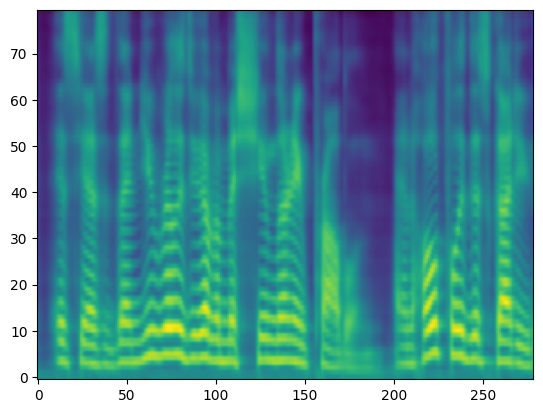

Real validation audio


SYNTHESIZED FOR -- Speaker: 42 | Dataset size: 5 mins | Mixing:False | Text:  excited enough about all the applications of machine learning that you want to watch further


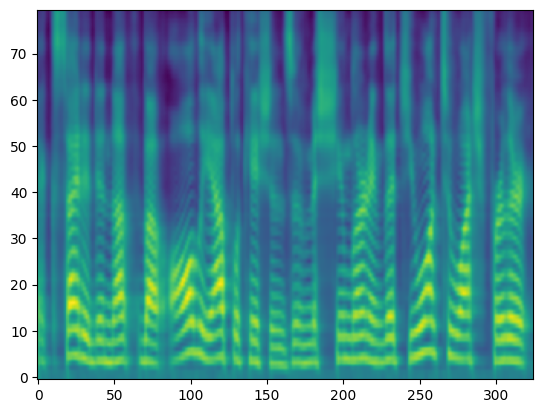

Real validation audio


SYNTHESIZED FOR -- Speaker: 42 | Dataset size: 5 mins | Mixing:False | Text:  videos that explain actually how to build these models and how to deploy these models. And


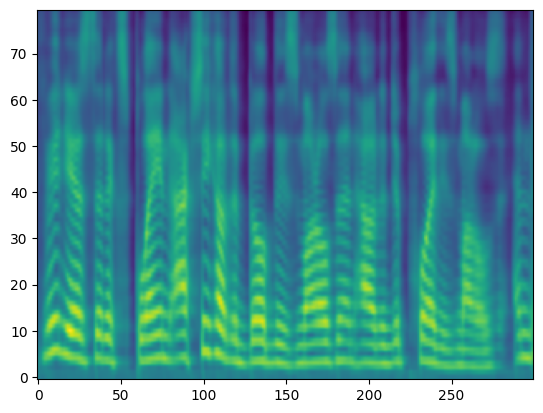

Real validation audio


SYNTHESIZED FOR -- Speaker: 42 | Dataset size: 5 mins | Mixing:False | Text:  we're going to keep creating these videos so you should probably subscribe so that you're the


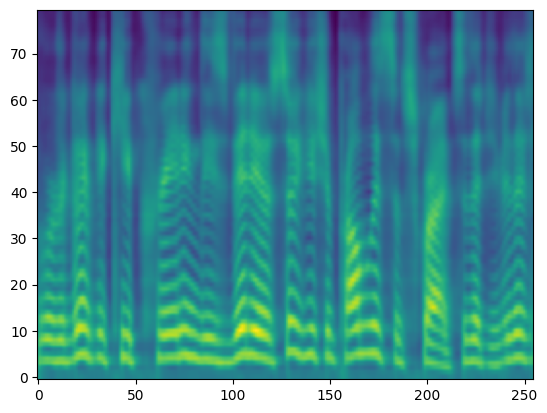

Real validation audio


SYNTHESIZED FOR -- Speaker: 42 | Dataset size: 5 mins | Mixing:False | Text:  first to know when a new video comes out.


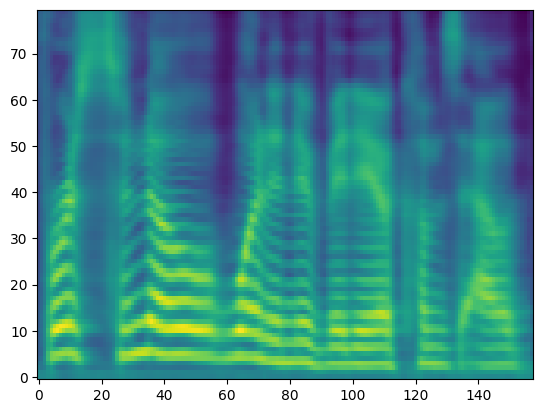

In [40]:
new_speaker_id = 42
duration_mins = 5
mixing = False
original_speaker_id = "ljspeech"

for _, val_record in valid_df.iterrows():
    print("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
    print(f"SYNTHESIZED FOR -- Speaker: {new_speaker_id} | Dataset size: {duration_mins} mins | Mixing:{mixing} | Text: {val_record['text']}")
    spec, audio = generate_audio(val_record["text"], new_speaker_id)
    ipd.display(ipd.Audio(audio, rate=22050))
    %matplotlib inline
    imshow(spec, origin="lower", aspect="auto")
    plt.show()

### The same on a wandb.Table

In [41]:
table = wandb.Table(columns=['Text', 'Real validation audio', f'Audio Speaker {new_speaker_id}', 'Spec'])

sample_rate=22050

for _, val_record in valid_df.iterrows():
    speaker_spec, speaker_audio = generate_audio(val_record['text'], speaker_id=new_speaker_id)
    row = [val_record["text_no_preprocessing"],
           wandb.Audio(val_record['audio_filepath'], sample_rate=sample_rate), 
           wandb.Audio(speaker_audio.flatten(), sample_rate=sample_rate),
           wandb.Image(speaker_spec)]
    table.add_data(*row)

wandb.log({"hifigan_predictions": table})

In [ ]:
wandb.finish()

### Running as a python program on a shell

We can then finetune hifigan similarly to fastpitch using NeMo's [hifigan_finetune.py](https://github.com/NVIDIA/NeMo/blob/main/examples/tts/hifigan_finetune.py) and [hifigan.yaml](https://github.com/NVIDIA/NeMo/blob/main/examples/tts/conf/hifigan/hifigan.yaml):

```bash
python examples/tts/hifigan_finetune.py \
--config-name=hifigan.yaml \
model.train_ds.dataloader_params.batch_size=32 \
model.max_steps=1000 \
model.optim.lr=0.00001 \
~model.optim.sched \
train_dataset=./hifigan_train_ft.json \
validation_datasets=./hifigan_val_ft.json \
exp_manager.exp_dir=hifigan_ft \
+init_from_pretrained_model=tts_hifigan \
trainer.check_val_every_n_epoch=10 \
model/train_ds=train_ds_finetune \
model/validation_ds=val_ds_finetune
```

Like when finetuning FastPitch, we lower the learning rate and get rid of the optimizer schedule for finetuning. You will need to create `<your_hifigan_val_manifest>` and the synthesized mels corresponding to it.

As mentioned, the above command is not runnable in Colab due to limited compute resources, but you are free to finetune HiFi-GAN on your own machines.

### Adding more data

We can add more data in two ways. They can be combined for the best effect:

* **Add more training data from the new speaker**

The entire notebook can be repeated from the top after a new JSON manifest is defined that includes the additional data. Modify your finetuning commands to point to the new manifest. Be sure to increase the number of steps as more data is added to both the FastPitch and HiFi-GAN finetuning.

We recommend **1000 steps per minute of audio for fastpitch and 500 steps per minute of audio for HiFi-GAN**.

* **Mix new speaker data with old speaker data**

We recommend finetuning FastPitch (but not HiFi-GAN) using both old speaker data (LJSpeech in this notebook) and the new speaker data. In this case, please modify the JSON manifests when finetuning FastPitch to include speaker information by adding a `speaker` field to each entry:

```
{"audio_filepath": "new_speaker.wav", "text": "sample", "duration": 2.6, "speaker": 1}
{"audio_filepath": "old_speaker.wav", "text": "LJSpeech sample", "duration": 2.6, "speaker": 0}
```

5 hours of data from the old speaker should be sufficient for training; it's up to you how much data from the old speaker to use in validation.

For the training manifest, since we likely have less data from the new speaker, we need to ensure that the model sees a similar amount of new data and old data. We can do this by repeating samples from the new speaker until we have an equivalent number of samples from the old and new speaker. For each sample from the old speaker, please add a sample from the new speaker in the .json.

As a toy example, if we use 4 samples of the old speaker and only 2 samples of the new speaker, we would want the order of samples in our manifest to look something like this:

```
old_speaker_sample_0
new_speaker_sample_0
old_speaker_sample_1
new_speaker_sample_1
old_speaker_sample_2
new_speaker_sample_0  # Start repeat of new speaker samples
old_speaker_sample_3
new_speaker_sample_1
```

Once the manifests are created, we can modify the FastPitch training command to point to the new training and validation JSON files.

We also need to update `model.n_speakers=1` to `model.n_speakers=2`, as well as update the `sup_data_types` specified in the config file to include `speaker_id` (`sup_data_types=[align_prior_matrix,pitch,speaker_id]`). Updating these two fields is very important--otherwise the model will not recognize that there is more than one speaker!

Ensure the pitch statistics correspond to the new speaker rather than the old speaker for best results.

**For HiFiGAN finetuning, the training should be done on the new speaker data.**